In [3]:
%matplotlib inline
import pandas as pd
from getdist import plots
from getdist import MCSamples

import matplotlib.pyplot as plt
import numpy as np
from cosmosis.postprocess import parser
from cosmosis.postprocessing.inputs import read_input
from cosmosis.postprocessing.postprocess import postprocessor_for_sampler
from cosmosis.postprocessing.plots import (
    MetropolisHastingsPlots2D,
    MetropolisHastingsPlots1D,
)


import math
from IPython.display import display, Math


In [4]:
%matplotlib inline
def generate_triangle_plot(data_path, params):
    """
    Generates a triangle plot for given parameters from the specified data path.
    
    Parameters:
        data_path (str): Path to the input data.
        params (list of tuples): List of tuples containing parameter names and fiducial values.
    """
    
    data_c = [read_input(data_path)][0]
        
    names = [param[0] for param in params]
    labels = [rf"{param[0]}" for param in params]  # LaTeX-style labels
    fiducial_values = {param[0]: param[1] for param in params}
    
    settings = {
        "mult_bias_correction_order": 0,
        "smooth_scale_2D": 3,
        "smooth_scale_1D": 3,
        "boundary_correction_order": 0,
    }
    data_so = [[line[i] for i in range(len(params))] for line in data_c[1]["data"][1][0]]   
    sample_red = MCSamples(samples=np.array(data_so[int(len(data_so) * 0.3) : ]), names=names, labels=labels, settings=settings)
    print(len(data_so))
    # Triangle plot
    g = plots.get_subplot_plotter()
    g.triangle_plot(
        [sample_red],
        filled=True,
        alphas=[0.8, 0.55],
        contour_ls="-",
        contour_lws=1,
        fine_bins=1,
        marker_args={"linewidth": 4},
        markers=fiducial_values,
    )
    plt.savefig(f'{data_path.replace('number_counts_samples.txt','triangle_plot.png')}')
    plt.show()

    for param_name in names:
        display(Math(sample_red.getInlineLatex(param_name, limit=1)))
    return data_so

LOADING CHAIN FROM FILE:  /sps/lsst/users/ebarroso/CLPipeline/examples/lsst_france/cosmodc2_scaling_relation_false/outputs/output_rp/number_counts_samples.txt
Removed no burn in
1200


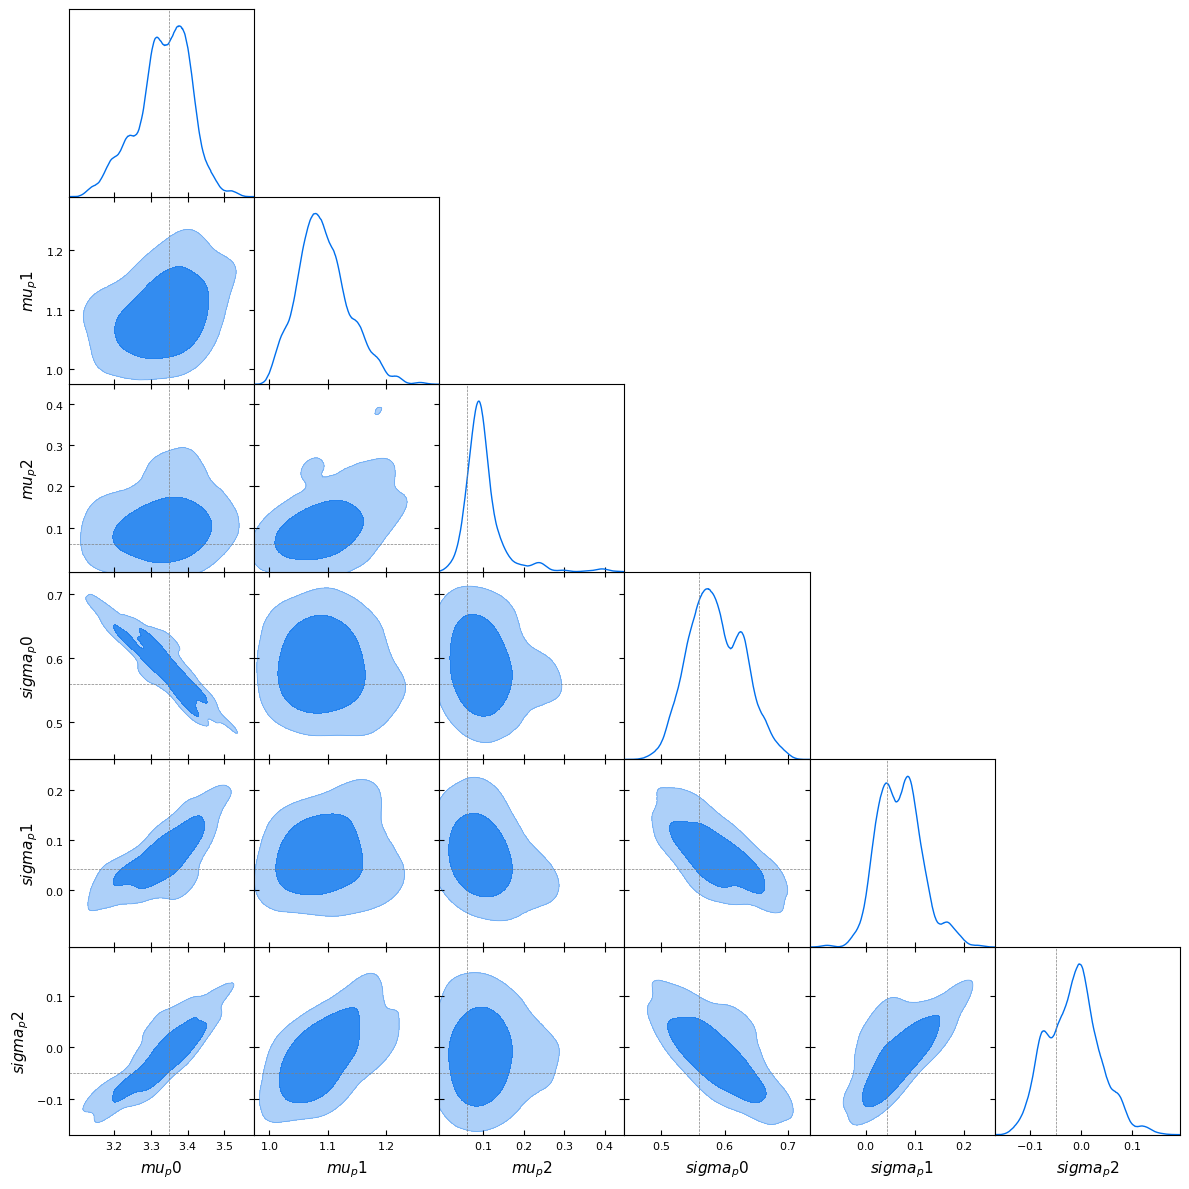

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[[np.float64(3.328833745020588),
  np.float64(0.9699871189877478),
  np.float64(0.0790424235934399),
  np.float64(0.5567046105342236),
  np.float64(0.019155536346320626),
  np.float64(-0.05671094873659519)],
 [np.float64(3.34989433733362),
  np.float64(0.9768875760466655),
  np.float64(0.0871311368233037),
  np.float64(0.5623574279969775),
  np.float64(0.021584742352733746),
  np.float64(-0.05950796982717371)],
 [np.float64(3.3446519938760173),
  np.float64(0.9835220967768232),
  np.float64(0.09074345728920008),
  np.float64(0.5459990619302825),
  np.float64(0.022928788596213057),
  np.float64(-0.051849786579961865)],
 [np.float64(3.339766809163284),
  np.float64(0.9981402835044049),
  np.float64(0.08978242176977165),
  np.float64(0.5614321754448304),
  np.float64(0.026208787521436606),
  np.float64(-0.055856829506820034)],
 [np.float64(3.3540473973594405),
  np.float64(0.9842434310614313),
  np.float64(0.08986236163786825),
  np.float64(0.5514486720385385),
  np.float64(0.026952211008

In [5]:
###Change the home path to yours
home = '/sps/lsst/users/ebarroso/'

generate_triangle_plot(home + "CLPipeline/examples/lsst_france/cosmodc2_scaling_relation_false/outputs/output_rp/number_counts_samples.txt", [
    ("mu_p0",3.35),
    ("mu_p1", 0.968),
    ("mu_p2", 0.06),
    ("sigma_p0", 0.56),
    ("sigma_p1", 0.043),
    ("sigma_p2", -0.05)
])

# ###We do not have fiducial values for this one. The ones here are just for illustration
# #generate_triangle_plot(home + "CLPipeline/examples/lsst_france/cosmodc2_scaling_relation/outputs/output_rp/number_counts_samples.txt", [
#     ("Omega_c", 0.22),
#     ("sigma_8", 0.800),
#     ("mu_p0",3.35),
#     ("mu_p1", 0.968),
#     ("mu_p2", 0.06),
#     ("sigma_p0", 0.56),
#     ("sigma_p1", 0.043),
#     ("sigma_p2", -0.05)
# ])